In [1]:
import os, re
import dill
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

## Load Data

* ### create df of name and label

In [2]:
img_path = os.path.join(os.getcwd(), "data/raw_data/img_nparrays")
# names = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]
names = [f for f in os.listdir(img_path) if any(c.isdigit() for c in f)]
labels = [re.sub(r'\d+', '', name) for name in names]
paths = [os.path.join(img_path, f) for f in names]
dict_df = pd.DataFrame(zip(names,paths, labels), columns=['name','path', 'label'], dtype=str)
dict_df.head()

,name,path,label
0,paper354,/Users/loaner/Documents/github/trash-classifie...,paper
1,cardboard188,/Users/loaner/Documents/github/trash-classifie...,cardboard
2,plastic389,/Users/loaner/Documents/github/trash-classifie...,plastic
3,paper166,/Users/loaner/Documents/github/trash-classifie...,paper
4,paper502,/Users/loaner/Documents/github/trash-classifie...,paper


* ### Sanity check: data size and distribution

total sample size: 2527
{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


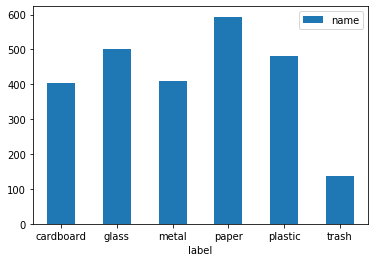

In [3]:
class_ct = dict_df.groupby(dict_df['label']).count()
print("total sample size: %d" % len(dict_df))
print(class_ct['name'].to_dict())
class_ct.reset_index().plot.bar(x='label', y='name', rot=0)

## Building SGD Classifier (online learn)

In [4]:
import skimage
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

* ### Data augmentation function

In [5]:
# transformations
def rotate(image_array: np.ndarray):
    '''rotate image with a random degree (between left_degree and right_degree)'''
    degree_limit = 30
    rotate_degree = random.uniform(-degree_limit, degree_limit)
    return skimage.transform.rotate(image_array, rotate_degree)*255

def add_noise(image_array: np.ndarray):
    '''add noise to image'''
    return skimage.util.random_noise(image_array)*255

def hor_flip(image_array: np.ndarray):
    '''flipping pixels horizontally'''
    return image_array[:, ::-1]

def ver_flip(image_array: np.ndarray):
    '''flipping pixels vertically'''
    return image_array[::-1, :]

transform_methods = [rotate, add_noise, hor_flip, ver_flip]

In [6]:
# function to make more images

def create_more_trash(target_num, base_file_paths, count_for_name):
    num_transformed = 0
    aug_img_df = pd.DataFrame(columns=dict_df.columns)
    
    base_folder = os.path.join('data/raw_data/resized', 'trash')
    aug_path = 'data/raw_data/aug_data'

    # delete if aug folder already exists (re-aug for every training set)
    if not os.path.exists(aug_path):
        os.mkdir(aug_path)
    else:
        for f in os.listdir(aug_path):
            os.remove(os.path.join(aug_path, f))
    
    while num_transformed <= target_num:
        rand_path = random.choice(base_file_paths)
        base_img = dill.load(open(rand_path, 'rb'))

        new_img = transform_methods[random.randint(0,3)](base_img).astype(np.uint8)
        num_transformed += 1
        
        new_img_name = "trash{}".format(str(count_for_name + num_transformed))
        new_img_path = os.path.join(aug_path, new_img_name)
        
        aug_img_df = aug_img_df.append({"name":new_img_name, "path":new_img_path, "label": "trash"},ignore_index=True)
        dill.dump(new_img, open(new_img_path, 'wb'))
#         imsave(os.path.join('data/raw_data/aug_data_check',new_img_name+".jpg"), new_img)
    return aug_img_df

In [7]:
# plot sample images
from PIL import Image

def plot_imgs_from_df(img_df):
    trash_fig = plt.figure(figsize = (15,15))
    row, col = (5,5)
    
    img_sample_df = img_df.sample(row*col).reset_index(drop=True)
    for index, row in img_sample_df.iterrows():
        img_arr = dill.load(open(row['path'], 'rb'))
        
        plt.subplot(5,5,index+1)
        plt.title(row['name'])
        plt.axis('off')
        
        plt.imshow(img_arr)

* ### Preprocessor

In [52]:
def split_and_aug(original_df, test_size):
    # train test split 
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(original_df, original_df['label'], \
                                                                    test_size=test_size)

    # data augmentation
    trash_base_df = X_train_df[X_train_df['label']=='trash']
    trash_base_paths = trash_base_df['path'].tolist()
    if len(trash_base_df[~trash_base_df['name'].str.contains('trash')])!=0:
        raise "label incorrect"  # sanity check
    else:
        avg_numb = int((len(X_train_df)- len(trash_base_paths))/5)
        trash_aug_numb = avg_numb - len(trash_base_paths)
        aug_trash_df = create_more_trash(trash_aug_numb, trash_base_paths, 137)
    
    # load the augmented data into training set
    X_train_df = X_train_df.append(aug_trash_df)
    y_train_df = y_train_df.append(aug_trash_df['label'])
    
    return X_train_df, X_test_df, y_train_df, y_test_df

* ### Feature Extraction

In [126]:
import cv2

def extract_orb(img):
    orb = cv2.ORB_create()
    keypts, descriptor = orb.detectAndCompute(img, None)
    return descriptor

* ### Batch Generator (for loading data incrementally)

In [12]:
class batch_generator():
    def __init__(self, train_df, test_df, batch_size=200, feature="color"):
#         self.train_df = train_df.sample(frac=1).reset_index(drop=True)  # shuffle train set
        self.train_df = train_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)
        self.batch_size = batch_size

    def get_batches(self, df):
        shuf_df = df.sample(frac=1).reset_index(drop=True) # shuffle train set
        for i in range(0, len(shuf_df), self.batch_size):
            paths = shuf_df['path'][i:i+self.batch_size]
            labels = shuf_df['label'][i:i+self.batch_size]
            im_arr = [dill.load(open(p, 'rb')).flatten() for p in paths]
            
            if feature == "color":
                imgs = np.asarray(im_arr)
            elif feature == "orb":
                imgs = np.asarray(extract_orb(i) for i in im_arr)
                
            yield imgs, labels
    
    def train_batches(self):
        return self.get_batches(self.train_df)
    
    def test_batches(self):
        paths = self.test_df['path']
        imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
        labels = self.test_df['label']
        return imgs, labels

* ### Model Function

In [93]:
class SGD():
    def __init__(self, _original_df, _test_size, _alpha, _batch_size, _n):
        self.original_df = _original_df
        self.test_size = _test_size
        self.alpha = _alpha
        self.batch_size = _batch_size
        self.n_iter = _n
    
    def train(self):    
        # train test split and data aug
        X_train_df, X_test_df, y_train_df, y_test_df = split_and_aug(self.original_df, self.test_size)

        # model
        clf = SGDClassifier(loss='hinge',shuffle=True, n_jobs=5, alpha=self.alpha)

        # batch generator
        batch_gen = batch_generator(X_train_df, X_test_df, batch_size=self.batch_size)

        # training
        n_iter = self.n_iter
        partial_train_scores = []
        for n in range(self.n_iter):
            counter = 0
            for X_train_batch, y_train_batch in batch_gen.train_batches():
                #print("training batch {} for {}th iter".format(counter, n))
                clf.partial_fit(X_train_batch, y_train_batch, \
                                classes=np.array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']))
                if counter>0:
                    partial_train_scores.append(clf.score(X_train_batch, y_train_batch))
                counter += 1
            print("finished iternation {}. total batches: {}".format(n, counter))

        # test set
        X_test, y_test = batch_gen.test_batches()

        self.X_test = X_test
        self.y_test = y_test
        self.clf = clf
        self.partial_train_scores = partial_train_scores
    
    def predict(self):
        y_pred = self.clf.predict(self.X_test)
        return y_pred
    
    def score_comps(self):
        test_score = self.clf.score(self.X_test, self.y_test)
        train_score_main = np.array(self.partial_train_scores).mean()
        return train_score_main, test_score

## Training with different setup

In [87]:
def results_df_setup(var_col_name, var_range, all_values):
    col_list = ['test_size', 'batch_size', 'alpha', 'n_iter', 'train_score_mean', 'test_score']
    results_df = pd.DataFrame(columns=col_list)
    var_index = col_list.index(var_col_name)
    for index, var in np.ndenumerate(np.asarray(var_range)):
        all_values[var_index] = var
        results_df.loc[index[0]] = all_values
    return results_df

In [77]:
import time

def record_results(results_df):
    for index, row in results_df.iterrows():
        checkpt = time.time()
        print("starting row: {}".format(index))
        
        sgd = SGD(dict_df, row.test_size, row.alpha, int(row.batch_size), int(row.n_iter))
        sgd.train()
        row.train_score_mean, row.test_score = sgd.score_comps()
        
        finish = time.time()
        print("finished row: {}, time lapsed: {}s".format(index, (finish-checkpt)/60))
    return results_df

In [109]:
def plot_curve(results_df, title, x_label, xscale="linear"):
    plt.figure()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Score")
    plt.ylim((0,1))
    plt.xscale(xscale)
    
    x = results_df[x_label]
    y_train_sc = results_df['train_score_mean']
    y_test_sc = results_df['test_score']
    
    plt.grid()

    plt.fill_between(x, y_train_sc.mean()-y_train_sc.std(), y_train_sc.mean()+y_train_sc.std(), alpha=0.1, color="r")
    plt.fill_between(x, y_test_sc.mean()-y_test_sc.std(), y_test_sc.mean()+y_test_sc.std(), alpha=0.1, color="g")
    plt.plot(x, y_train_sc, 'o-', color="r", label="Training score")
    plt.plot(x, y_test_sc, 'o-', color="g",label="Test score")

    plt.legend(loc="best")

* ### with different test sizes

In [57]:
test_size_vary_df = pd.DataFrame(columns=['test_size', 'batch_size', 'alpha', 'n_iter', 'train_score_mean', 'test_score'])

In [ ]:
for index, size in np.ndenumerate(np.linspace(0.03, 0.3, 5)):
    test_size_vary_df.loc[index[0]]=[size, 200, 0.01, 6, 0, 0]

In [65]:
import time

for index, row in test_size_vary_df.iterrows():
    checkpt = time.time()
    print("starting row: {}".format(index))
          
    sgd = SGD(dict_df, row.test_size, row.alpha, int(row.batch_size), int(row.n_iter))
    sgd.train()
    row.train_score_mean, row.test_score = sgd.score_comps()
    
    finish = time.time()
    print("finished row: {}, time lapsed: {}s".format(index, (finish-checkpt)/60))

starting row: 0
training batch 0 for 0th iter
training batch 1 for 0th iter
training batch 2 for 0th iter
training batch 3 for 0th iter
training batch 4 for 0th iter
training batch 5 for 0th iter
training batch 6 for 0th iter
training batch 7 for 0th iter
training batch 8 for 0th iter
training batch 9 for 0th iter
training batch 10 for 0th iter
training batch 11 for 0th iter
training batch 12 for 0th iter
training batch 13 for 0th iter
training batch 0 for 1th iter
training batch 1 for 1th iter
training batch 2 for 1th iter
training batch 3 for 1th iter
training batch 4 for 1th iter
training batch 5 for 1th iter
training batch 6 for 1th iter
training batch 7 for 1th iter
training batch 8 for 1th iter
training batch 9 for 1th iter
training batch 10 for 1th iter
training batch 11 for 1th iter
training batch 12 for 1th iter
training batch 13 for 1th iter
training batch 0 for 2th iter
training batch 1 for 2th iter
training batch 2 for 2th iter
training batch 3 for 2th iter
training batch 4

training batch 9 for 2th iter
training batch 10 for 2th iter
training batch 0 for 3th iter
training batch 1 for 3th iter
training batch 2 for 3th iter
training batch 3 for 3th iter
training batch 4 for 3th iter
training batch 5 for 3th iter
training batch 6 for 3th iter
training batch 7 for 3th iter
training batch 8 for 3th iter
training batch 9 for 3th iter
training batch 10 for 3th iter
training batch 0 for 4th iter
training batch 1 for 4th iter
training batch 2 for 4th iter
training batch 3 for 4th iter
training batch 4 for 4th iter
training batch 5 for 4th iter
training batch 6 for 4th iter
training batch 7 for 4th iter
training batch 8 for 4th iter
training batch 9 for 4th iter
training batch 10 for 4th iter
training batch 0 for 5th iter
training batch 1 for 5th iter
training batch 2 for 5th iter
training batch 3 for 5th iter
training batch 4 for 5th iter
training batch 5 for 5th iter
training batch 6 for 5th iter
training batch 7 for 5th iter
training batch 8 for 5th iter
trainin

In [66]:
test_size_vary_df

,test_size,batch_size,alpha,n_iter,train_score_mean,test_score
0,0.0300,200.0,0.01,6.0,0.372777,0.302632
1,0.0975,200.0,0.01,6.0,0.364034,0.352227
2,0.1650,200.0,0.01,6.0,0.366670,0.273381
3,0.2325,200.0,0.01,6.0,0.381966,0.362245
4,0.3000,200.0,0.01,6.0,0.368861,0.324111


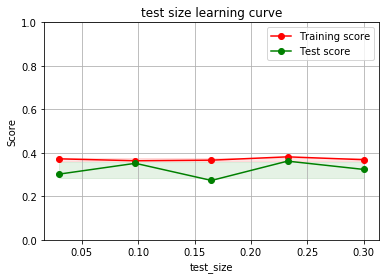

In [110]:
plot_curve(test_size_vary_df, "test size learning curve", 'test_size')

* ### with different batch sizes

In [94]:
batch_vary_df = results_df_setup('batch_size', np.linspace(50,400,8),[0.1, 0, 0.01, 6, 0, 0])
record_results(batch_vary_df)

starting row: 0
finished iternation 0. total batches: 52
finished iternation 1. total batches: 52
finished iternation 2. total batches: 52
finished iternation 3. total batches: 52
finished iternation 4. total batches: 52
finished iternation 5. total batches: 52
finished row: 0, time lapsed: 3.1115344007809957s
starting row: 1
finished iternation 0. total batches: 26
finished iternation 1. total batches: 26
finished iternation 2. total batches: 26
finished iternation 3. total batches: 26
finished iternation 4. total batches: 26
finished iternation 5. total batches: 26
finished row: 1, time lapsed: 2.938724863529205s
starting row: 2
finished iternation 0. total batches: 18
finished iternation 1. total batches: 18
finished iternation 2. total batches: 18
finished iternation 3. total batches: 18
finished iternation 4. total batches: 18
finished iternation 5. total batches: 18
finished row: 2, time lapsed: 3.2656329313913983s
starting row: 3
finished iternation 0. total batches: 13
finished

,test_size,batch_size,alpha,n_iter,train_score_mean,test_score
0,0.1,50.0,0.01,6.0,0.395916,0.367589
1,0.1,100.0,0.01,6.0,0.378094,0.229249
2,0.1,150.0,0.01,6.0,0.377205,0.276680
3,0.1,200.0,0.01,6.0,0.388592,0.276680
4,0.1,250.0,0.01,6.0,0.373133,0.308300
5,0.1,300.0,0.01,6.0,0.376505,0.221344
6,0.1,350.0,0.01,6.0,0.369442,0.335968
7,0.1,400.0,0.01,6.0,0.376762,0.276680


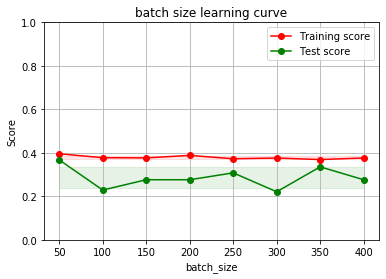

In [96]:
plot_curve(batch_vary_df, "batch size learning curve", 'batch_size')

* ### with different alpha

In [103]:
alpha_vary_df = results_df_setup('alpha', 1/np.logspace(0,5,6), [0.1, 350, 0.01, 5, 0, 0])
record_results(alpha_vary_df)

starting row: 0
finished iternation 0. total batches: 8
finished iternation 1. total batches: 8
finished iternation 2. total batches: 8
finished iternation 3. total batches: 8
finished iternation 4. total batches: 8
finished row: 0, time lapsed: 2.3321174661318462s
starting row: 1
finished iternation 0. total batches: 8
finished iternation 1. total batches: 8
finished iternation 2. total batches: 8
finished iternation 3. total batches: 8
finished iternation 4. total batches: 8
finished row: 1, time lapsed: 2.2422513802846273s
starting row: 2
finished iternation 0. total batches: 8
finished iternation 1. total batches: 8
finished iternation 2. total batches: 8
finished iternation 3. total batches: 8
finished iternation 4. total batches: 8
finished row: 2, time lapsed: 2.4312188148498537s
starting row: 3
finished iternation 0. total batches: 8
finished iternation 1. total batches: 8
finished iternation 2. total batches: 8
finished iternation 3. total batches: 8
finished iternation 4. tot

,test_size,batch_size,alpha,n_iter,train_score_mean,test_score
0,0.1,350.0,1.00000,5.0,0.326535,0.332016
1,0.1,350.0,0.10000,5.0,0.340278,0.411067
2,0.1,350.0,0.01000,5.0,0.356303,0.229249
3,0.1,350.0,0.00100,5.0,0.340633,0.320158
4,0.1,350.0,0.00010,5.0,0.383662,0.379447
5,0.1,350.0,0.00001,5.0,0.357895,0.229249


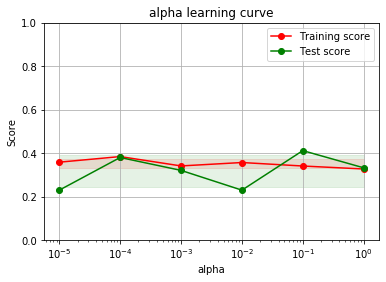

In [111]:
plot_curve(alpha_vary_df, "alpha learning curve", 'alpha', xscale='log')

* ### with different n_iter

In [121]:
n_vary_df = results_df_setup('n_iter', np.arange(1,22,5), [0.1, 350, 0.0001, 1, 0, 0])
record_results(n_vary_df)

starting row: 0
finished iternation 0. total batches: 8
finished row: 0, time lapsed: 0.6351942658424378s
starting row: 1
finished iternation 0. total batches: 8
finished iternation 1. total batches: 8
finished iternation 2. total batches: 8
finished iternation 3. total batches: 8
finished iternation 4. total batches: 8
finished iternation 5. total batches: 8
finished row: 1, time lapsed: 3.1227925022443137s
starting row: 2
finished iternation 0. total batches: 8
finished iternation 1. total batches: 8
finished iternation 2. total batches: 8
finished iternation 3. total batches: 8
finished iternation 4. total batches: 8
finished iternation 5. total batches: 8
finished iternation 6. total batches: 8
finished iternation 7. total batches: 8
finished iternation 8. total batches: 8
finished iternation 9. total batches: 8
finished iternation 10. total batches: 8
finished row: 2, time lapsed: 5.55971698363622s
starting row: 3
finished iternation 0. total batches: 8
finished iternation 1. tota

,test_size,batch_size,alpha,n_iter,train_score_mean,test_score
0,0.1,350.0,0.0001,1.0,0.270483,0.252964
1,0.1,350.0,0.0001,6.0,0.348758,0.205534
2,0.1,350.0,0.0001,11.0,0.400936,0.371542
3,0.1,350.0,0.0001,16.0,0.430048,0.300395
4,0.1,350.0,0.0001,21.0,0.441425,0.355731


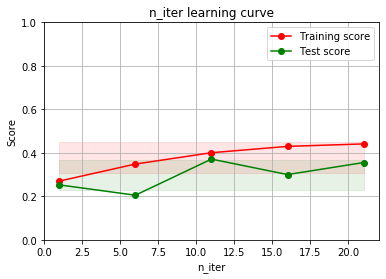

In [122]:
plot_curve(n_vary_df, "n_iter learning curve", 'n_iter')

based on these results, we would use {test_size=0.1, batch_size=350, alpha =0.0001, n_iter=12} to train.

## Feature Extraction

* ### Orb feature